In [0]:
from google.colab import drive
drive.mount('/content/My_Drive')

Mounted at /content/My_Drive


In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

## 1. Data loading and cleaning

### 1.1Creating a DB using csv

In [0]:
%%time 

import os
import time
import datetime as dt
from sqlalchemy import create_engine
import pandas as pd

if not os.path.isfile('/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/Train.db'):

    disk_engine = create_engine('sqlite:///train.db')   #creating the engine
    chunksize = 180000                                  #creating number of rows first and then iterating again to the rest of the data
    
    j = 0
    index_start = 1

    for df in pd.read_csv('/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start  #start the index as 1
        j+=1
        print('{} rows'.format(j*chunksize))  #next set of rows taken after 180000
        df.to_sql('data', disk_engine, if_exists='append')  #creating the sql table as 'data'
        index_start = df.index[-1]+1                        # once appended all the index and came out of the loop as index_start becomes higher than number of index   




<string>:2: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.


180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
CPU times: user 2min 45s, sys: 17.8 s, total: 3min 3s
Wall time: 6min 19s


In [0]:
!cp /content/train.db '/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train.db'

In [0]:
# syncing the cache file to the drive from colab
from google.colab import drive
drive.flush_and_unmount()

### 1.2Counting the number of rows

In [0]:
# check whether the train.db is in my drive
import os
os.path.exists('/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train.db')

True

In [0]:
%%time

import sqlite3

if os.path.exists('/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train.db'):
    conn = sqlite3.connect('/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train.db')
    num_rows = pd.read_sql_query('''select count(*) from data''', conn)
    conn.close()

CPU times: user 141 ms, sys: 209 ms, total: 350 ms
Wall time: 3min 41s


In [0]:
num_rows

,count(*)
0,6394196


In [0]:
print('Number of rows in train data:', num_rows['count(*)'][0])

Number of rows in train data: 6394196


### 1.3 Checking for duplicates

In [0]:
%%time

if os.path.exists('/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train.db'):
    con = sqlite3.connect('/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as count_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()

CPU times: user 32.4 s, sys: 26.6 s, total: 59 s
Wall time: 9min 54s


In [0]:
df_no_dup.head()

,Title,Body,Tags,count_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [0]:
print('Total number of data points:', num_rows['count(*)'].values)
print('Total number of duplicate points:', df_no_dup.shape[0])
print('% of points duplicated in train data:', (1 - ( df_no_dup.shape[0]/num_rows['count(*)'].values) )*100)

Total number of data points: [6034196]
Total number of duplicate points: 4206315
% of points duplicated in train data: [30.29203891]


In [0]:
df_no_dup['count_dup'].value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: count_dup, dtype: int64

In [0]:
#counting the number of tags in each question
%%time

df_no_dup['count_tag'] = df_no_dup['Tags'].apply(lambda x : len(str(x).split(' ')))
df_no_dup.head()

CPU times: user 2.84 s, sys: 4.26 ms, total: 2.84 s
Wall time: 2.84 s


In [0]:
df_no_dup.head()

,Title,Body,Tags,count_dup,count_tag
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [0]:
#distribution of number of tages per question
df_no_dup['count_tag'].value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: count_tag, dtype: int64

### 1.4 Creating the database with no duplicates

In [0]:
if not os.path.exists('/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train_no_dup.db'):
    disk_dup = create_engine('sqlite:///train_no_dup.db')   #creating a new db with no duplicates
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])   #creating a new df without duplicates but contains less columns as (Title, Body, Tags)
    no_dup.to_sql('no_dup_train', disk_dup)                                #writing the df(here no_dup) records to db(here engine) by creating the sql table ('no_dup_train)

In [0]:
!cp /content/train_no_dup.db '/content/My_Drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train_no_dup.db'

In [0]:
# syncing the cache file to the drive from colab
from google.colab import drive
drive.flush_and_unmount()

### 1.5 Getting a connection with the no_dup database
- Train.csv - csv file
- train.db  - train database
- df_no_dup - dataframe with no duplicates (title, Body, tags, count_dup, count_tags)
- train_no_dup.db - database with no duplicates
- no_dup - dataframe with no duplicates (title, body, tags)
- no_dup_train - sql table (created by pd.to_sql(NAME of the sql table, database name))

In [0]:
from google.colab import drive
drive.mount('/content/My_Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/My_Drive


In [0]:
import os
import sqlite3
import pandas as pd

In [0]:
os.path.exists('/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train_no_dup.db')

True

In [0]:
%%time

#https://stackoverflow.com/questions/31986520/show-tables-in-sqlite-database-in-python

if os.path.isfile('/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train_no_dup.db'):

    #creating a connection to db
    con = sqlite3.connect('/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train_no_dup.db')
    print('connection success')

    #creating the cursor obj
    cursor_obj = con.cursor()

    #listing what the database has
    cursor_obj.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
    print(cursor_obj.fetchall())
    con.close()

connection success
[('no_dup_train',)]
CPU times: user 989 µs, sys: 747 µs, total: 1.74 ms
Wall time: 4.51 ms


#### Note:
- Now, we know that the database contains the no_dup_train table we can create a dataframe from there

In [0]:
con = sqlite3.connect('/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train_no_dup.db')
tag_data = pd.read_sql_query('''SELECT Tags FROM no_dup_train''', con)
con.close()

In [0]:
tag_data.head()

,Tags
0,c++ c
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc


In [0]:
#looking for the null value 
tag_data[tag_data.isnull().any(1)]

,Tags
777547,None
962680,None
1126558,None
1256102,None
2430668,None
3329908,None
3551595,None


In [0]:
#removing the null values
tag_data.dropna(axis=0, inplace=True)
print(tag_data.isnull().sum())

Tags    0
dtype: int64


## 2. Analysis of Tags

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

#before we just create a normal countvectorizer and it will remove all the stop words , punctuation, extra spaces
#but here we need all of the those that's why we need custom tokenizer which is "splitting the given string and tokenize it"
vec = CountVectorizer(tokenizer = lambda x:x.split(' '))
tag_dtm = vec.fit_transform(tag_data['Tags'])

In [0]:
print('Total number of data points:', tag_dtm.shape[0])
print('Total number of unique tags:', tag_dtm.shape[1])

Total number of data points: 4206308
Total number of unique tags: 42048


In [0]:
tags = vec.get_feature_names()
print('some of the tags:', tags[:10])

some of the tags: ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### 2.1 Distribution of tags

In [0]:
#no_of_times_each_tag_appears is nothing but adding each tag across all data points
# (ie) tag_dtm is of shape = 4206308 x 42048, where 42048 represents unique tag if we add each tag across all data points
#it will give how many times each tag appears in our dataset
no_of_times_each_tag_appears = tag_dtm.sum(axis=0).A1  #tag_dtm.sum(axis=0) returns (1, 42048) and tag_dtm.sum(axis=0).A1 returns (42048,)
result = dict(zip(tags, no_of_times_each_tag_appears))

In [0]:
#dictionary to csv file
#https://stackoverflow.com/questions/8685809/writing-a-dictionary-to-a-csv-file-with-one-line-for-every-key-value

import csv
if not os.path.isfile('/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/tag_counts_dict_dtm.csv'):
    with open('/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for k,v in result.items():
            writer.writerow([k,v])

In [0]:
tag_df = pd.read_csv('/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/tag_counts_dict_dtm.csv', names=['Tags', 'counts'])
tag_df.head()

,Tags,counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [0]:
tag_df.shape

(42048, 2)

In [0]:
#sorting it 
tag_df_sorted = tag_df.sort_values(['counts'], ascending=False)

tag_df_sorted.head()

,Tags,counts
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436


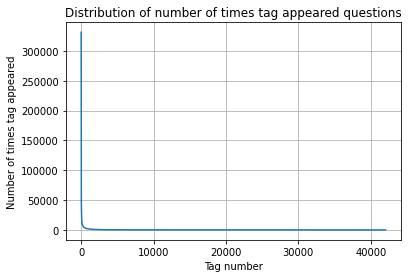

In [0]:
#plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(tag_df_sorted['counts'].values)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

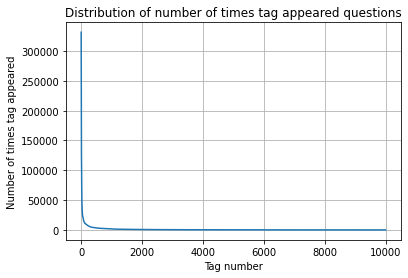

In [0]:
#plot first 10000
plt.plot(tag_df_sorted['counts'].values[0:10000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

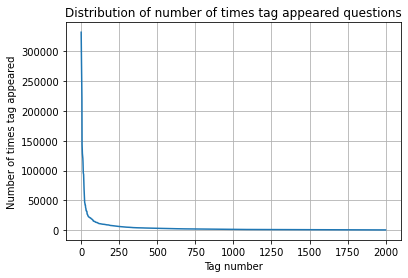

In [0]:
#first 2000
plt.plot(tag_df_sorted['counts'].values[0:2000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

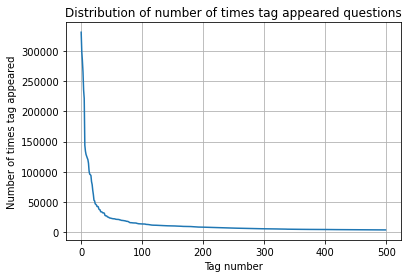

In [0]:
#first 500
plt.plot(tag_df_sorted['counts'].values[0:500])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

In [0]:
#store tags greater than 10k in one list
list_greater_than_10k = tag_df[tag_df['counts']>10000]['Tags']
print ('{} Tags are used more than 10000 times'.format(len(list_greater_than_10k)))

#store tags greater than 100k in one list
list_greater_than_100k = tag_df[tag_df['counts']>100000]['Tags']
print ('{} Tags are used more than 10000 times'.format(len(list_greater_than_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 10000 times


#### 2.2 No of Tags per Question

In [0]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()
print(tag_quest_count[0:10])

[[2], [3], [4], [2], [2], [3], [3], [2], [2], [2]]


In [0]:
#making list of list to list ---> https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
tag_quest_count = [int(j) for i in tag_quest_count for j in i]

print('total no of data points:', len(tag_quest_count))
print('number of tags for first 5 questions:', tag_quest_count[:5])

total no of data points: 4206308
number of tags for first 5 questions: [2, 3, 4, 2, 2]


In [0]:
from statistics import mean
print(max(tag_quest_count))
print(min(tag_quest_count))
print(mean(tag_quest_count))

5
1
2.8994424564249694


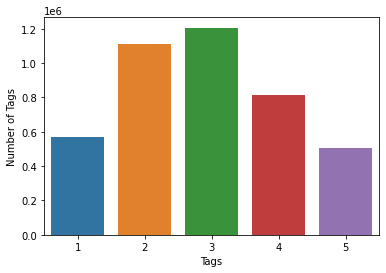

In [0]:
import seaborn as sns
sns.countplot(tag_quest_count)
plt.xlabel('Tags')
plt.ylabel('Number of Tags')
plt.show()

### 2.3 Important words - wordcloud

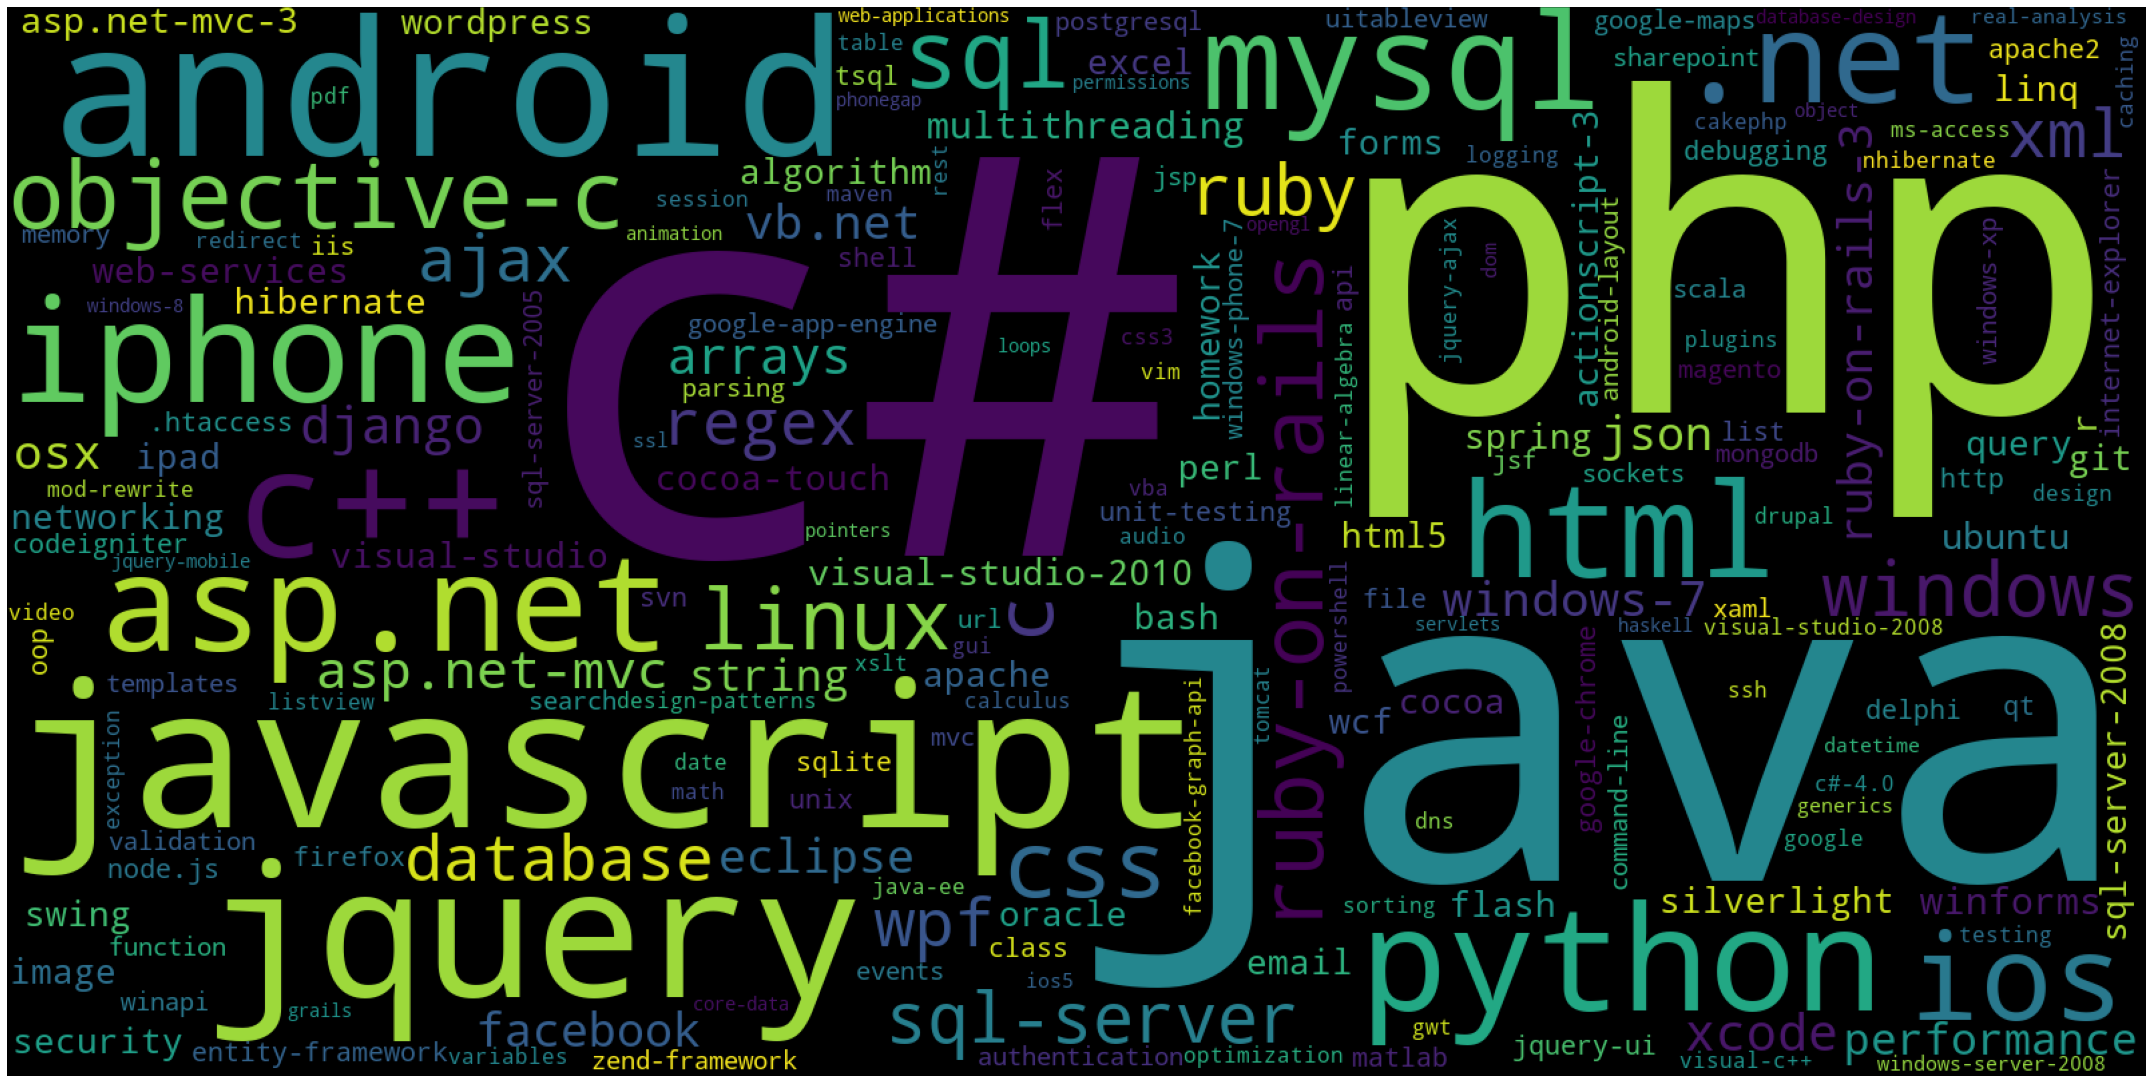

In [0]:
from wordcloud import WordCloud

word_cloud = WordCloud(background_color='black',
                          width=1600,
                          height=800).generate_from_frequencies(result)

plt.figure(figsize=(30,20))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout()
plt.show()

In [0]:
tag_df_sorted.head()

,Tags,counts
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436


### 2.4 Top 20 tags

In [0]:
#plot top 20 tags
top_20 = tag_df_sorted[0:20]

top_20.head()

,Tags,counts
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436


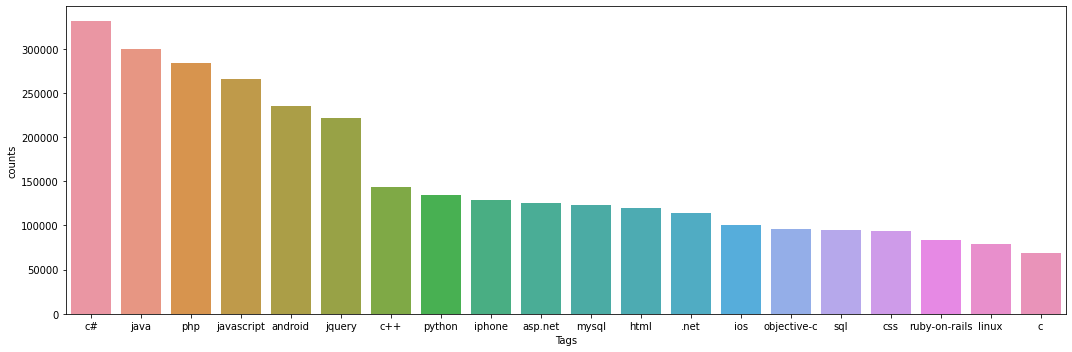

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(x='Tags', y='counts', data=top_20)
plt.tight_layout()
plt.show()

## 3. Data cleaning

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 3.1 Remove HTML tags

In [0]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def strip_html(data):
    clean = re.compile('<.*?>')
    clean_text = re.sub(clean, ' ',str(data))
    return clean_text

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

### 3.2 Create a connection in db, create a table and see if it exists and Create a database table

In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
# we are taking 1000000 data points from "train_no_dup.db" database to "Processed.db" database
import os
from datetime import datetime
start = datetime.now()

read_db = '/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train_no_dup.db'
write_db = '/content/Processed.db'

#creating a connection on train_no_dup.db and no_dup_train is a table in it
if os.path.isfile(read_db):
    conn_r = create_connection(read_db) 

    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute('SELECT Title, Body, Tags from no_dup_train ORDER BY RANDOM() LIMIT 1000000')

#creating a connection to Processed.db
if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer = conn_w.cursor()
        if tables != 0:
            writer.execute('DELETE FROM QuestionsProcessed WHERE 1 ')
            print('cleared all the rows')

print('Time taken to run this cell:', datetime.now() - start)

### 3.3 Cleaning the code, title and question

In [0]:
from nltk.tokenize import word_tokenize

start = datetime.now()
reader.fetchone()
question_with_code = 0
len_pre = 0
len_post = 0
question_processed = 0
preprocessed_data_list = []

for row in reader:
    is_code = 0
    title, question, tags = row[0], row[1], row[2]

    #PRE
    #1. no of question with code
    if '<code>' in question:
        question_with_code += 1
        is_code = 1
    x = len(question) + len(title)
    len_pre += x

    #2.code
    code = re.findall('<code>(.*?)</code>', question, flags = re.DOTALL)

    #3. question
    question = re.sub('<code>(.*?)</code>', '', question, flags = re.DOTALL | re.MULTILINE)
    question = strip_html(question.encode('utf-8'))

    #4. title
    title = title.encode('utf-8')

    #POST
    #change question into question + title
    question = str(question) + ' ' + str(title)
    question = re.sub(r'[^A-Za-z]+', ' ', question)
    words = tokenize(str(question.lower()))

    #remove all the single letter and stop word from question except C
    question = ' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post += len(question)
    tup = (question, code, tags, x, len(question), is_code)
    question_processed += 1
    writer.execute('INSERT INTO QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?', tup)
    if (question_processed%100000 ==0):
        print('Number of questions completed',question_processed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

In [0]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

### 3.4 Taking 1M points to a Data Frame

In [0]:
#https://vaex.readthedocs.io/en/latest/installing.html
import vaex as vx

import pandas as pd
import os
import sqlite3

In [0]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [0]:
write_db = '/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/Copy of Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)

    if conn_r is not None:
        #cursr = conn_r.cursor()
        #str = "select name from sqlite_master where type='table'"
        #table_names = cursr.execute(str)
        #print("Tables in the databse:")
        #tables =table_names.fetchall() 
        #QuestionProceesed = tables[0][0]
        preprocessed_data = pd.read_sql_query('SELECT Question, Tags from QuestionsProcessed', conn_r)

conn_r.commit()
conn_r.close()

In [0]:
import pandas as pd
processed_data = pd.read_csv('/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/Processed_data.csv', index_col=[0])
processed_data.head()

,question,tags
0,chang cpu soni vaio pcg grx tri everywher find...,cpu motherboard sony-vaio replacement disassembly
1,display size grayscal qimag qt abl display ima...,c++ qt qt4
2,datagrid selecteditem set back null eventtocom...,mvvm silverlight-4.0
3,filter string collect base listview item resol...,c# winforms string listview collections
4,disabl home button without use type keyguard c...,android android-layout android-manifest androi...


## 4. Data Modelling

### 4.1 Converting tags for multilabel problem

In [0]:
%%time
processed_data.isna().sum()

question    0
tags        3
dtype: int64

In [0]:
processed_data[processed_data.isnull().any(1)]

,question,tags
603831,realli need null possibl duplic purpos null ac...,NaN
764660,page null pleas ensur oper perform context asp...,NaN
890718,find valu null anoth tabl run problem result o...,NaN


In [0]:
%%time 

#removing the null value rows
processed_data.dropna(axis=0, inplace=True)
processed_data.isna().sum()

CPU times: user 528 ms, sys: 3.98 ms, total: 532 ms
Wall time: 535 ms


question    0
tags        0
dtype: int64

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
multilabel_y = vectorizer.fit_transform(processed_data['tags'])

In [0]:
multilabel_y[0:5]

<5x35422 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

### 4.2 Top Tags to choose

In [0]:
#whether argsort gives the same as sorted(range(len(a)), key=lambda i : a[i], reverse=True)
import numpy as np
a = [32,4,6,3,2,6,2]
print(sorted(range(len(a)), key=lambda i : a[i], reverse=True))
print((np.argsort(-1*np.array(a))).tolist())

[0, 2, 5, 1, 3, 4, 6]
[0, 2, 5, 1, 3, 4, 6]


In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags = (np.argsort(-1*np.array(t))).tolist()
    multilabel_yn = multilabel_y[:, sorted_tags[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return np.count_nonzero(x==0)    # this line will says how much the top n tags explained the questions

In [0]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_ques = multilabel_y.shape[0]

for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_ques - questions_explained_fn(i))/total_ques)*100, 3))

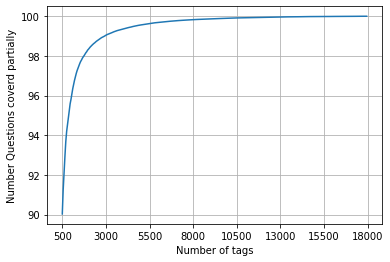

with  5500 tags we are covering  99.039 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [0]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_ques)

number of questions that are not covered : 9613 out of  999996


In [0]:
print('Number of tags in sample',multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample 35422
number of tags taken : 5500 ( 15.527073570097679 %)


### 4.3 Split into train and test

In [0]:
total_size=processed_data.shape[0]
train_size=int(0.80*total_size)

x_train=processed_data.head(train_size)
x_test=processed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799996, 5500)
Number of data points in test data : (200000, 5500)


### 4.4 Featurizing data

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(min_df=0.00009, max_df=200000, tokenizer=lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vec.fit_transform(x_train['question'])
X_test_multilabel = vec.transform(x_test['question'])

### 4.5 Applying Logistic Regression

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

In [0]:
# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.081965
macro f1 score : 0.0963020140154
micro f1 scoore : 0.374270748817
hamming loss : 0.00041225090909090907
Precision recall report :
              precision    recall  f1-score   support

          0       0.62      0.23      0.33     15760
          1       0.79      0.43      0.56     14039
          2       0.82      0.55      0.66     13446
          3       0.76      0.42      0.54     12730
          4       0.94      0.76      0.84     11229
          5       0.85      0.64      0.73     10561
          6       0.70      0.30      0.42      6958
          7       0.87      0.61      0.72      6309
          8       0.70      0.40      0.50      6032
          9       0.78      0.43      0.55      6020
         10       0.86      0.62      0.72      5707
         11       0.52      0.17      0.25      5723
         12       0.55      0.10      0.16      5521
         13       0.59      0.25      0.35      4722
         14       0.61      0.22      0.32      4468


### 4.6 Modelling with 0.5M points and giving more weightage to title

In [0]:
import sqlite3
import os

In [0]:
def create_database_table(database, query):
    #creating a connection
    conn = sqlite3.connect(database)
    
    if conn is not None:
        #creating a table using the query
        c = conn.cursor()
        c.execute(query)

        #check whether the table exists in db
        str = "select name from sqlite_master where type='table'"
        table_names = c.execute(str)
        print("Tables in the databse:")
        tables =table_names.fetchall() 
        print(tables[0][0])
        return(len(tables))

    else:
        print("Error! cannot create the database connection.")
    conn.close()

In [0]:
#create a database with more weights to title
sql_query_create_table = 'CREATE TABLE IF NOT EXISTS QuestionProcessed (question text NOT NULL, code TEXT, tags TEXT, words_pre INTEGER, words_post INTEGER, is_code INTEGER)'
create_database_table('TitleMoreWeight.db', sql_query_create_table)

Tables in the databse:
QuestionProcessed


1

In [0]:
#reading from train_no_dup.db and take 0.5M points to TitleMoreWeight.db
read_db = '/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/train_no_dup.db'
write_db = 'TitleMoreWeight.db'

#train_data_size = 400000
if os.path.isfile(read_db):
    conn_r = sqlite3.connect(read_db)

    if conn_r is not None:
        reader = conn_r.cursor()

        #CHECK FOR THE TABLE
        str = 'SELECT name from sqlite_master where type="table"'
        table_names = reader.execute(str)
        tables = table_names.fetchall()
        print('Table in train_no_dup.db:', tables)

        #take 0.5M points from no_train_dup table in train_no_dup.db
        reader.execute('SELECT Title, Body, Tags FROM no_dup_train LIMIT 500001')

#writing
if os.path.isfile(write_db):
    conn_w = sqlite3.connect(write_db)

    if conn_w is not None:
        writer = conn_w.cursor()
        
        #check for the tables
        str = 'SELECT name from sqlite_master where type="table"'
        table_names = writer.execute(str)
        tables = table_names.fetchall()
        print('Table in TitleMoreWeight.db:', tables)

        if tables !=0:
            writer.execute('DELETE FROM QuestionProcessed WHERE 1')
            print("Cleared All the rows")


Table in train_no_dup.db: [('no_dup_train',)]
Table in TitleMoreWeight.db: [('QuestionProcessed',)]
Cleared All the rows


### 4.6.1 Processing of questions
1. Separate Code from Body
2. Remove Spcial characters from Question title and description (not in code)
3. Give more weightage to title : Add title three times to the question

In [0]:
from nltk.tokenize import word_tokenize

reader.fetchone()
question_with_code = 0
len_pre = 0
len_post = 0
questions_processed = 0

for row in reader:
    is_code = 0
    title, question, tags = row[0], row[1], row[2]
    
    #PRE
    if '<code>' in question:
        question_with_code += 1
        is_code = 1
    x = len(question) + len(title)
    len_pre += x

    #POST
    code = re.findall(r'<code>(.*?)</code>', '', question, flags=re.DOTALL)
    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question = strip_html(question.encode('utf-8'))

    title = title.encode('utf-8')
    question = str(title) +" "+ str(title) +" "+ str(title) +" "+ question
    
    #remove all the non alphabets
    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words = word_tokenize(str(question.lower()))

    #remove all the stopwordsexcept 'c' and stem it 
    question = ' '.join(str(stemmer.stem(i)) for i in question if not in stop_words and (len(i)!=1 or i=='c'))
    
    len_post += len(question)
    tup = (question,code,tags,x,len(question),is_code)
    question_processed += 1
    writer.execute('INSERT INTO QuestionProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)', tup)
    if (question_processed/100000==0):
        print("number of questions completed=",question_proccesed)

no_dup_avg_len_pre = (len_pre*1.0) /question_processed
no_dup_avg_len_post = (len_post*1.0)/question_processed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%questions_with_code*100.0/questions_processed)

In [0]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [0]:
#reading from pickle file
import pandas as pd
write_db = '/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/Copy of Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [0]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [0]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

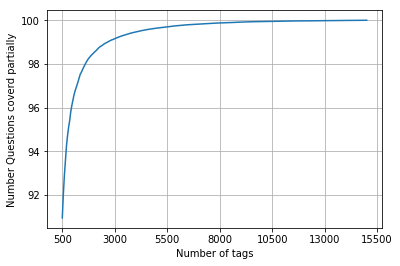

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [0]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [0]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


<h3> 4.5.2 Featurizing data with TfIdf vectorizer </h3>

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:52.522389


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Diamensions of train data X: (400000, 94927) Y : (400000, 500)
Diamensions of test data X: (100000, 94927) Y: (100000, 500)


<h3> 4.5.3 Applying Logistic Regression with OneVsRest Classifier </h3>

In [0]:
#Logistic Regression using SGDClassifier
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23623
Hamming loss  0.00278088
Micro-average quality numbers
Precision: 0.7216, Recall: 0.3256, F1-measure: 0.4488
Macro-average quality numbers
Precision: 0.5473, Recall: 0.2572, F1-measure: 0.3339
             precision    recall  f1-score   support

          0       0.94      0.64      0.76      5519
          1       0.69      0.26      0.38      8190
          2       0.81      0.37      0.51      6529
          3       0.81      0.43      0.56      3231
          4       0.81      0.40      0.54      6430
          5       0.82      0.33      0.47      2879
          6       0.87      0.50      0.63      5086
          7       0.87      0.54      0.67      4533
          8       0.60      0.13      0.22      3000
          9       0.81      0.53      0.64      2765
         10       0.59      0.17      0.26      3051
         11       0.70      0.33      0.45      3009
         12       0.64      0.24      0.35      2630
         13       0.71      0.23      0.35   

In [0]:
#Normal logistic regression
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.25108
Hamming loss  0.00270302
Micro-average quality numbers
Precision: 0.7172, Recall: 0.3672, F1-measure: 0.4858
Macro-average quality numbers
Precision: 0.5570, Recall: 0.2950, F1-measure: 0.3710
             precision    recall  f1-score   support

          0       0.94      0.72      0.82      5519
          1       0.70      0.34      0.45      8190
          2       0.80      0.42      0.55      6529
          3       0.82      0.49      0.61      3231
          4       0.80      0.44      0.57      6430
          5       0.82      0.38      0.52      2879
          6       0.86      0.53      0.66      5086
          7       0.87      0.58      0.70      4533
          8       0.60      0.13      0.22      3000
          9       0.82      0.57      0.67      2765
         10       0.60      0.20      0.30      3051
         11       0.68      0.38      0.49      3009
         12       0.62      0.29      0.40      2630
         13       0.73      0.30      0.43   

# **5.Task 1: using ngram_range=(1,4) for micro-f1 score** 
- Apllying ngram_range=(1,4)

In [0]:
import sqlite3
import pandas as pd

read_db = '/content/drive/My Drive/Assignment 21 - Stack_Overflow_tag_predictor/Copy of Titlemoreweight.db'

conn_r = sqlite3.connect(read_db)
cursr = conn_r.cursor()
str = "select name from sqlite_master where type='table'"
table_names = cursr.execute(str)
print("Tables in the databse:")
tables =table_names.fetchall() 
print(tables)
#QuestionProceesed = tables[0][0]
print('='*25,'Calculating preprocessed_data_halfM', '='*25)
preprocessed_data_halfM = pd.read_sql_query('SELECT Question, Tags from QuestionsProcessed', conn_r)

conn_r.close()

Tables in the databse:
[('QuestionsProcessed',)]
========================= Calculating preprocessed_data_halfM =========================


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
!pwd

/home/ubuntu/Project


In [0]:
preprocessed_data_halfM = pd.read_csv('/home/ubuntu/Project/preprocessed_halfM_data.csv')

In [0]:
preprocessed_data_halfM.head()

,Unnamed: 0,question,tags
0,0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


### 5.1 converting string tags into multiple output variables

In [0]:
vectorizer = CountVectorizer(tokenizer=lambda x:x.split(), binary=True)
multilabel_y = vectorizer.fit_transform(preprocessed_data_halfM['tags'])

### 5.2 select top 500 tags 

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags = (np.argsort(-1*np.array(t))).tolist()
    multilabel_yn = multilabel_y[:, sorted_tags[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return np.count_nonzero(x==0)    # this line will says how much the top n tags explained the questions

In [0]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data_halfM.shape[0]

for  i in range(500, total_tags,100):
    questions_explained.append(np.round(((total_qs - questions_explained_fn(i))/total_qs)*100, 3))

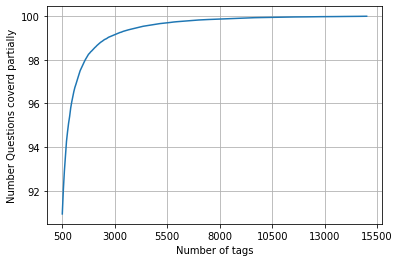

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.937 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [0]:
multilabel_yx = tags_to_choose(500)
print('The number of ques that are note covered:',questions_explained_fn(500), 'out of ', total_qs)

The number of ques that are note covered: 45315 out of  500000


In [0]:
x_train=preprocessed_data_halfM.head(400000)
x_test=preprocessed_data_halfM.tail(preprocessed_data_halfM.shape[0] - 400000)

y_train = multilabel_yx[0:400000,:]
y_test = multilabel_yx[400000:preprocessed_data_halfM.shape[0],:]

### 5.1 Applying ngram_range(1,4)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(min_df=0.00009, max_df=200000, tokenizer=lambda x: x.split(), ngram_range=(1,4))
X_train_assignment = vec.fit_transform(x_train['question'])
X_test_assignment = vec.transform(x_test['question'])

In [0]:
print("Dimensions of train data X:",X_train_assignment.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",X_test_assignment.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 95585) Y : (400000, 500)
Dimensions of test data X: (100000, 95585) Y: (100000, 500)


In [0]:
#pickling out
import pickle
file = open('X_train_assignment.pkl', 'wb')
pickle.dump(X_train_assignment, file)


file = open('X_test_assignment.pkl', 'wb')
pickle.dump(X_test_assignment, file)

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

classifier_1 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier_1.fit(X_train_assignment, y_train)

In [0]:
predictions = classifier_1.predict(X_test_assignment)

In [0]:
from sklearn import metrics
print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.23679
macro f1 score : 0.33522432510001804
micro f1 scoore : 0.44846989963239525
hamming loss : 0.00278162
Precision recall report :
               precision    recall  f1-score   support

           0       0.94      0.64      0.76      5519
           1       0.69      0.26      0.38      8190
           2       0.82      0.37      0.51      6529
           3       0.82      0.43      0.56      3231
           4       0.81      0.40      0.54      6430
           5       0.82      0.34      0.48      2879
           6       0.87      0.49      0.63      5086
           7       0.88      0.54      0.67      4533
           8       0.60      0.13      0.22      3000
           9       0.81      0.52      0.63      2765
          10       0.59      0.16      0.25      3051
          11       0.70      0.33      0.45      3009
          12       0.65      0.25      0.36      2630
          13       0.71      0.23      0.35      1426
          14       0.90      0.53      0.6

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

# **6. Task -2:**
- Grid Search for Logistic Regression

In [0]:
print(X_train_assignment.shape)
print(y_train.shape)

(400000, 95585)
(400000, 500)


In [0]:
#https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier
from sklearn.model_selection import GridSearchCV

parameters = [
              {
                  'estimator__alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
              }
            ]

grid_search = GridSearchCV(estimator=classifier_1, param_grid=parameters, scoring='f1_micro', cv=2, n_jobs=-1, return_train_score=True)            

In [0]:
grid_search = grid_search.fit(X_train_assignment ,y_train)

In [0]:
grid_search.best_params_.items()

dict_items([('estimator__alpha', 1e-05)])

In [0]:
for k,v in grid_search.best_params_.items():
    best_alpha = v
    
print('Best alpha:', v)

Best alpha: 1e-05


# **7.Task-3:**
- Applying SVM

In [0]:
print("Dimensions of train data X:",X_train_assignment.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",X_test_assignment.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 95585) Y : (400000, 500)
Dimensions of test data X: (100000, 95585) Y: (100000, 500)


In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.1, penalty='l1', random_state=42), n_jobs=-1)
classifier.fit(X_train_assignment, y_train)
predictions = classifier.predict(X_test_assignment)

In [0]:
print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.12096
macro f1 score : 0.0
micro f1 scoore : 0.0
hamming loss : 0.00347572
Precision recall report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5519
           1       0.00      0.00      0.00      8190
           2       0.00      0.00      0.00      6529
           3       0.00      0.00      0.00      3231
           4       0.00      0.00      0.00      6430
           5       0.00      0.00      0.00      2879
           6       0.00      0.00      0.00      5086
           7       0.00      0.00      0.00      4533
           8       0.00      0.00      0.00      3000
           9       0.00      0.00      0.00      2765
          10       0.00      0.00      0.00      3051
          11       0.00      0.00      0.00      3009
          12       0.00      0.00      0.00      2630
          13       0.00      0.00      0.00      1426
          14       0.00      0.00      0.00      2548
          15       0

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Summary:

In [1]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model', 'Loss', 'Accuracy', 'Micro F1 Score', 'Macro F1 Score', 'Hamming Loss']

x.add_row(['OnevsRest Classifier', 'log', 0.23679, 0.3352243, 0.448469, 0.002781])
x.add_row(['OnevsRest Classifier', 'hinge', 0.12096, 0.0, 0.0, 0.00347572])

print(x)

+----------------------+-------+----------+----------------+----------------+--------------+
|        Model         |  Loss | Accuracy | Micro F1 Score | Macro F1 Score | Hamming Loss |
+----------------------+-------+----------+----------------+----------------+--------------+
| OnevsRest Classifier |  log  | 0.23679  |   0.3352243    |    0.448469    |   0.002781   |
| OnevsRest Classifier | hinge | 0.12096  |      0.0       |      0.0       |  0.00347572  |
+----------------------+-------+----------+----------------+----------------+--------------+


## That's the end of the code